<h1 style="text-align: center;">Final Project</h1>
<h2 style="text-align: center;">02807 Computational Tools for Data Science</h2>
<p style="text-align: center;">Authors: s241645, s242689, s253167, s253095</p>

# 0. Prelude
This notebook contains a compilation of the code for the final project of the course 02807 Computational Tools for Data Science. The actual work was done using separate py scripts to create a more modular and manageable training pipeline.

Please refer to our [GitHub repository](https://github.com/sunnakaradottir/data_science) for the complete codebase, including all py scripts, config files, HPC job submission scripts, and additional documentation.

## 1. Introduction

Credit card fraud is rare, only about 0.2% of transactions in the dataset are fraudulent. This makes it difficult to train a model to recognize fraud directly, since there are so few examples to learn from.

Instead, we take an anomaly detection approach: we train a model to learn what normal transactions look like. Transactions that don't fit this learned pattern are flagged as potential fraud.

**Method:**
1. Cluster normal transactions using K-Means
2. Train a separate AutoEncoder for each cluster
3. Classify transactions with high reconstruction error as fraudulent

In [65]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    davies_bouldin_score
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## 2. Data Overview

The dataset contains credit card transactions from European cardholders in September 2013. Features V1-V28 are PCA-transformed (for privacy), while `Time` and `Amount` are original features.

In [66]:
import kagglehub
import os
import shutil

# Download latest version and set under data/
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

data_dir = os.path.join(path, "data")

target_path = "./data"
os.makedirs(target_path, exist_ok=True)

# Move dataset contents to ./data/
for filename in os.listdir(data_dir):
    src = os.path.join(data_dir, filename)
    dst = os.path.join(target_path, filename)

    if os.path.isfile(src):  # Skip directories
        shutil.copy(src, dst)

df = pd.read_csv(os.path.join(target_path, 'creditcard.csv') )


print("First 5 records:", df.head())
print(f"Shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

fraud_count = df['Class'].sum()
normal_count = len(df) - fraud_count

print(f"Normal transactions: {normal_count} ({100 * normal_count / len(df):.2f}%)")
print(f"Fraudulent transactions: {fraud_count} ({100 * fraud_count / len(df):.2f}%)")

df.describe() # quick overview of the data

Path to dataset files: /Users/arnormoncada/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
First 5 records:    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.64

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 3. Data Preprocessing

We split the data into two sets:
- **Base data**: Normal transactions only — used to train the AutoEncoders
- **Tune data**: All fraud + a sample of normal — used to find optimal thresholds and evaluate

We also standardize features using `StandardScaler` fitted only on normal data.

In [67]:
import os

def prepare_tune_split(
    source_path: str = 'data/creditcard.csv',
    tune_out_path: str = 'data/tune_data.csv',
    base_out_path: str = 'data/base_data.csv',
    seed: int = 42,
    times: int = 4,   # how many normals per fraud in tune set
) -> dict:
    """
    Create:
    - tune_data.csv: all fraud + `times` * n_fraud normals (or fewer if not enough)
    - base_data.csv: the rest of the data (here: all remaining normal transactions)

    base_data.csv will be used for clustering and AE training.
    tune_data.csv will be used ONLY for threshold tuning.
    """

    # Resolve paths relative to this file
    dir_path = os.getcwd()
    data_path = os.path.join(dir_path, source_path)
    tune_path = os.path.join(dir_path, tune_out_path)
    base_path = os.path.join(dir_path, base_out_path)

    # Load full dataset
    df = pd.read_csv(data_path)
    if 'Class' not in df.columns:
        raise ValueError("Expected a 'Class' column in the dataset")

    # Partition by class
    df_normal = df[df['Class'] == 0].copy()
    df_fraud  = df[df['Class'] == 1].copy()

    n_fraud = len(df_fraud)
    if n_fraud == 0:
        raise ValueError("No fraudulent samples (Class==1) found in dataset")

    # --- Build tune set: all fraud + times * fraud normals (sampled) ---
    n_norm_for_tune = min(len(df_normal), n_fraud * times)
    df_normal_tune = df_normal.sample(n=n_norm_for_tune, random_state=seed, replace=False)

    # Indices in the ORIGINAL df that will be in tune_df
    used_idx = df_fraud.index.union(df_normal_tune.index)

    # Build tune_df directly from df using those indices, then shuffle
    tune_df = df.loc[used_idx].sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # --- Base set: everything not in tune_df ---
    base_df = df.drop(index=used_idx).reset_index(drop=True)

    # Sanity: base_df should contain only normal (Class == 0)
    assert (base_df['Class'] == 0).all(), "base_df should contain only normal samples"

    # Save CSVs
    tune_df.to_csv(tune_path, index=False)
    base_df.to_csv(base_path, index=False)

    summary = {
        "paths": {
            "tune": tune_path,
            "base": base_path,
        },
        "counts": {
            "total": int(len(df)),
            "normal_total": int(len(df_normal)),
            "fraud_total": int(n_fraud),
            "tune_normal": int((tune_df['Class'] == 0).sum()),
            "tune_fraud": int((tune_df['Class'] == 1).sum()),
            "base_normal": int((base_df['Class'] == 0).sum()),
        },
    }

    print("Splits created and saved to:")
    print(f"  tune -> {tune_path}  (normal={summary['counts']['tune_normal']}, fraud={summary['counts']['tune_fraud']})")
    print(f"  base -> {base_path}  (normal={summary['counts']['base_normal']})")

    return summary

In [ ]:
# Prepare the tune split
prepare_tune_split(source_path='data/creditcard.csv')

base_df = pd.read_csv('data/base_data.csv')
tune_df = pd.read_csv('data/tune_data.csv')

print("Base data (training):")
print(f"  {len(base_df)} samples, {base_df['Class'].sum()} fraud")

print("\nTune data (threshold tuning + evaluation):")
print(f"  {len(tune_df)} samples, {tune_df['Class'].sum()} fraud")

# Load pre-fitted scaler (fitted on normal data only)
X_base = base_df.drop(columns=['Class'])
scaler = StandardScaler()
X_base_scaled = scaler.fit_transform(X_base)

print(f"Before scaling - Mean: {X_base.values.mean():.2f}, Std: {X_base.values.std():.2f}")
print(f"After scaling  - Mean: {X_base_scaled.mean():.2f}, Std: {X_base_scaled.std():.2f}")

Splits created and saved to:
  tune -> /Users/arnormoncada/Documents/DTU/H25/ctfds/data_science/notebooks/data/tune_data.csv  (normal=1968, fraud=492)
  base -> /Users/arnormoncada/Documents/DTU/H25/ctfds/data_science/notebooks/data/base_data.csv  (normal=282347)
Base data (training):
  282347 samples, 0 fraud

Tune data (threshold tuning + evaluation):
  2460 samples, 492 fraud
Before scaling - Mean: 3164.23, Std: 19103.81
After scaling  - Mean: 0.00, Std: 1.00


## 4. Clustering
Normal transactions aren't uniform because of different spending patterns, amounts, times, etc. Rather than training one model on all data, we cluster similar transactions and train a specific AutoEncoder on each cluster.

### 4.1 K-Means Implementation
We implemented the K-Means algorithm ourselves:

In [69]:
def kmeans_implementation(X, k, max_iters=300, tol=0.0001, random_state=42) -> tuple[np.ndarray, np.ndarray]:
    """
    A simple implementation of the K-means clustering algorithm.
    Parameters:
    - X: Input data, scaled numpy array of shape (n_samples, n_features).
    - k: Number of clusters.
    - max_iters: Maximum number of iterations.
    - tol: Tolerance to declare convergence.
    - random_state: Seed for reproducibility.
    """

    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    data = np.asarray(X)
    n_samples, n_features = data.shape

    # Randomly choose initial centroids
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = data[indices, :]

    for iteration in range(max_iters):
        # Assign points to nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            points = data[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                # Reinitialize empty cluster randomly
                new_centroids[i] = data[np.random.randint(0, n_samples)]

        # Check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

class OurKmeans:
    def __init__(self, centroids: np.ndarray):
        self.centroids = centroids  # shape: (k, n_features)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Assign each row in X to the nearest centroid."""
        X = np.asarray(X)
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        return np.argmin(distances, axis=1)

### 4.2 Choosing K
We use two methods to determine the optimal number of clusters:
- **Elbow method**: Look for the "elbow" where inertia stops decreasing significantly
- **Davies-Bouldin index**: Lower values indicate better-defined clusters

Converged after 21 iterations.
Converged after 26 iterations.
Converged after 29 iterations.
Converged after 43 iterations.
Converged after 33 iterations.
Converged after 37 iterations.
Converged after 37 iterations.
Converged after 39 iterations.
Converged after 41 iterations.


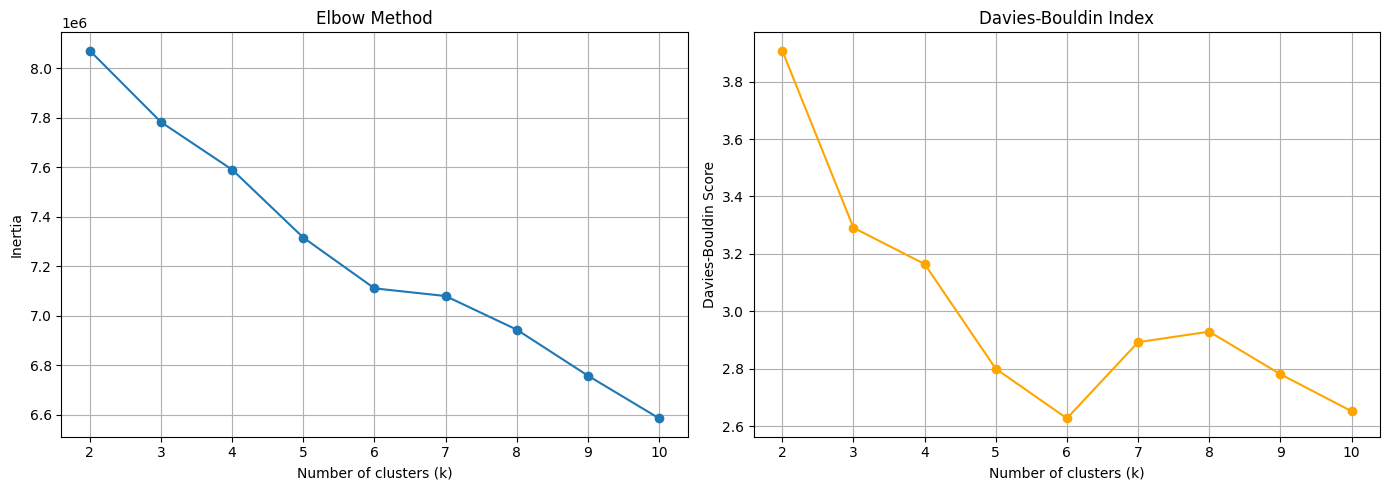

In [70]:
def compute_inertia(data, labels, centroids):
    if hasattr(data, 'to_numpy'):
        data = data.to_numpy()
    inertia = 0.0
    for i, point in enumerate(data):
        inertia += np.sum((point - centroids[labels[i]]) ** 2)
    return inertia

inertias = []
db_scores = []
k_range = range(2, 11)

for k in k_range:
    labels, centroids = kmeans_implementation(X_base_scaled, k)
    inertias.append(compute_inertia(X_base_scaled, labels, centroids))
    db_scores.append(davies_bouldin_score(X_base_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, db_scores, marker='o', color='orange')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Davies-Bouldin Index')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 4.3 Clustering Normal Transactions
With K=4 selected based on the elbow method and Davies-Bouldin index, we apply K-Means to segment the normal transactions. (kannski aðeins að henda betri rökstuðningi hingað..?)

In [71]:
K = 4
cluster_labels, centroids = kmeans_implementation(X_base_scaled, k=K, random_state=42)
kmeans = OurKmeans(centroids=centroids) # for future predictions

print("Cluster distribution:")
for i in range(K):
    count = (cluster_labels == i).sum()
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {i}: {count:,} samples ({pct:.1f}%)")

Converged after 29 iterations.
Cluster distribution:
  Cluster 0: 33,591 samples (11.9%)
  Cluster 1: 19,755 samples (7.0%)
  Cluster 2: 137,615 samples (48.7%)
  Cluster 3: 91,386 samples (32.4%)


### 4.4 Cluster Visualization

We use PCA to project the high-dimensional data into 2D and 3D for visualization....

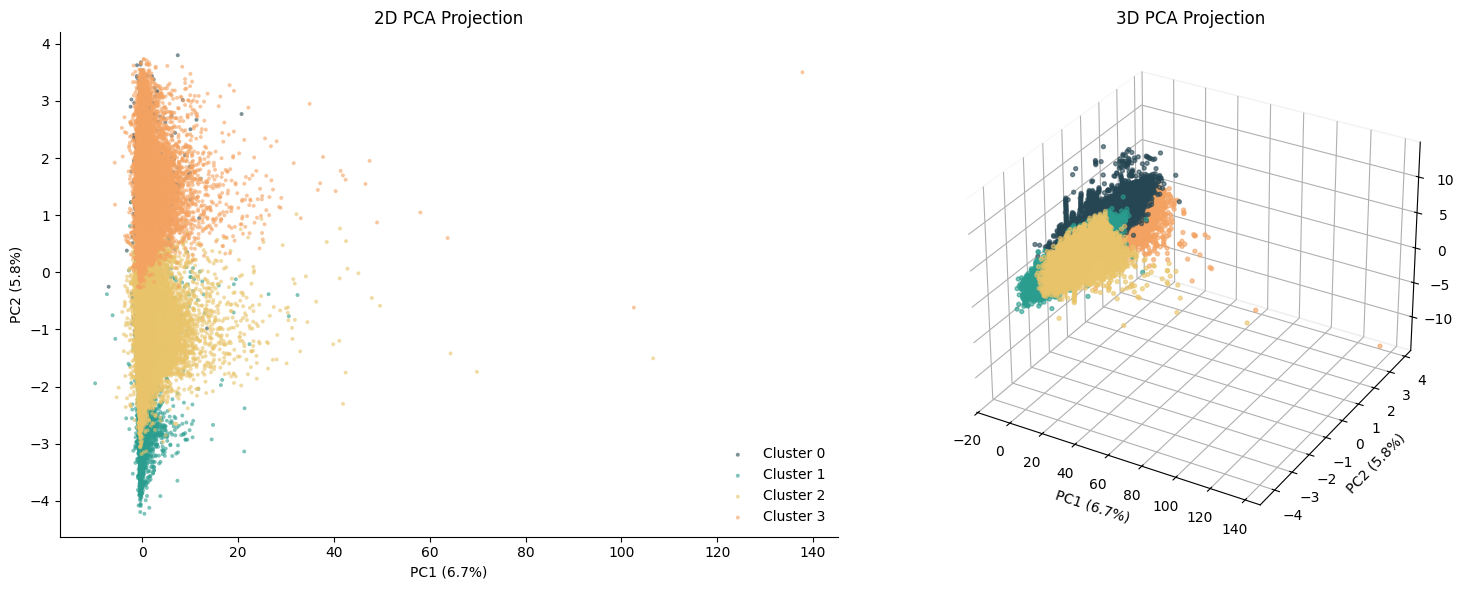

In [72]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_base_scaled)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_base_scaled)
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261']
fig = plt.figure(figsize=(16, 6))

# 2D plot
ax1 = fig.add_subplot(121)
for i in range(K):
    mask = cluster_labels == i
    ax1.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], c=colors[i], label=f'Cluster {i}', alpha=0.6, s=8, edgecolors='none')

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('2D PCA Projection')
ax1.legend(frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 3D plot
ax2 = fig.add_subplot(122, projection='3d')
for i in range(K):
    mask = cluster_labels == i
    ax2.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2], c=colors[i], label=f'Cluster {i}', alpha=0.6, s=8)

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)')
ax2.set_title('3D PCA Projection')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False

plt.tight_layout()
plt.show()

## 5. Model Architecture and Training
### 5.1 AutoEncoder
An AutoEncoder is a neural network that learns to compress its input from the oberved space $R^N$ into a small representation in the latent space $R^M$ (where $M < N$), then reconstruct the original input from that compressed form.

The network has two parts: 
1. An encoder $f$, parametrized by $\theta$, which maps input $x$ to a latent representation $z$ i.e. $f_\theta : x \rightarrow z$
2. A decoder $g$, parametrized by $\phi$, which maps the latent representation back to the input space i.e. $g_\phi : z \rightarrow \hat{x}$

The idea is that the autoencoder will learn the compressed representation of normal transactions. When it sees a fraudulent transaction, it won't be able to reconstruct it well, leading to a high reconstruction error [1].

Reconstruction error calculation is distance based in the observed space $R^N$, in our case we use Mean Squared Error (MSE):
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2
$$

Because we train the model only on normal transactions, it learns what "normal" looks like. When we later pass a transaction through the model, we measure how well it reconstructs the input. Normal transactions are reconstructed accurately (low error), while fraudulent transactions, which the model has never seen, are reconstructed poorly (high error). This reconstruction error becomes our anomaly score.

In [73]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim=30, hidden_units=64, latent_features=2, num_layers=1):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure meaning that the decoder should be an encoder in reverse.
        
        def init_encoder_decoder(in_features, out_features, hidden_units, num_layers):
            '''
            Create an encoder / decoder with a dynamic number of layers
            '''
            layers = []

            # First layer
            layers.append(nn.Linear(in_features, hidden_units)),
            layers.append(nn.ReLU())

            for _ in range(num_layers-1):
                layers.append(nn.Linear(hidden_units, hidden_units))
                layers.append(nn.ReLU())

            # Final layer
            layers.append(nn.Linear(hidden_units, out_features))

            return nn.Sequential(*layers)

        self.encoder = init_encoder_decoder(in_dim, latent_features, hidden_units, num_layers)
        self.decoder = init_encoder_decoder(latent_features, in_dim, hidden_units, num_layers)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return {
            'z': z,
            'x_hat': x_hat
        }

### 5.4 Hyperparameter Optimization

To find the best hyperparameters for each cluster, we used [Weights & Biases (wandb) sweeps](https://docs.wandb.ai/models/sweeps) . A sweep systematically searches through combinations of hyperparameters and tracks performance to help identify the optimal hyperparameter configuration.

The training sweeps were done on DTU's HPC cluster.

**Hyperparameters search space:**
- `hidden_dim`: Number of neurons in hidden layers (32, 64, 128, 256, 512, 1024)
- `num_layers`: Depth of encoder/decoder (1, 2, 3, 4, 5, 6, 7, 8)
- `lr`: Learning rate (0.0001 to 0.1)
- `batch_size`: Samples per gradient update (32, 64, 128, 256, 512, 1024)
- `weight_decay`: L2 regularization (0.0, 1e-6, 1e-5)
- `epochs`: Training epochs (10, 20, 30, 40, 50, 70, 90, 100)

For each cluster, the sweep ran multiple training runs (around 50 per cluster model) with different configurations to find the best performing hyperparameters based on validation loss.

In [74]:
def parse_model_config(config_path):
    config = {}
    with open(config_path, 'r') as f:
        for line in f:
            if ':' in line:
                key, value = line.split(':', 1)
                key, value = key.strip(), value.strip()
                if value.isdigit():
                    value = int(value)
                else:
                    try:
                        value = float(value)
                    except ValueError:
                        pass
                config[key] = value
    return config

print("Optimal hyperparameters found via wandb sweeps:\n")
for cid in range(K):
    config = parse_model_config(f'../models/ae_cluster_{cid}/ae_cluster_{cid}_config.txt')
    print(f"Cluster {cid}:")
    print(f"  hidden_dim: {config.get('hidden_dim')}")
    print(f"  latent:     {config.get('latent')}")
    print(f"  num_layers: {config.get('num_layers')}")
    print(f"  lr:         {config.get('lr')}")
    print(f"  batch_size: {config.get('batch_size')}")
    print(f"  weight_decay: {config.get('weight_decay')}")
    print(f"  epochs:     {config.get('epochs')}")
    print(f"  seed:       {config.get('seed')}")
    print(f"  best_val_mse: {config.get('best_val_mse'):.4f}")
    print()

Optimal hyperparameters found via wandb sweeps:

Cluster 0:
  hidden_dim: 1024
  latent:     8
  num_layers: 1
  lr:         0.007599338223792307
  batch_size: 1024
  weight_decay: 0
  epochs:     100
  seed:       42
  best_val_mse: 0.0677

Cluster 1:
  hidden_dim: 512
  latent:     8
  num_layers: 4
  lr:         0.0003663209242790148
  batch_size: 512
  weight_decay: 1e-05
  epochs:     50
  seed:       42
  best_val_mse: 0.1261

Cluster 2:
  hidden_dim: 1024
  latent:     8
  num_layers: 1
  lr:         0.043401408988612285
  batch_size: 1024
  weight_decay: 1e-05
  epochs:     50
  seed:       42
  best_val_mse: 0.1252

Cluster 3:
  hidden_dim: 64
  latent:     8
  num_layers: 1
  lr:         0.01402564371766035
  batch_size: 512
  weight_decay: 1e-06
  epochs:     10
  seed:       42
  best_val_mse: 0.1202



### 5.2 Per-Cluster Models
Rather than training one model on all data, we train a separate AutoEncoder for each cluster. This specialization aims to enable each model to learn the reconstruction patterns unique to its transaction type, with the goal of improving anomaly sensitivity.

1. Split cluster data → 80% train, 20% validation
2. Create an AutoEncoder with the config settings
3. For each epoch:
   - Feed batches through network
   - Calculate reconstruction error (MSE)
   - Update weights to reduce error
   - Record train & validation loss
4. Return the trained model + loss history

In [75]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_on_cluster(X_cluster: np.ndarray, in_dim: int, cfg, cid: int):
    X_train, X_val = train_test_split(X_cluster, test_size=cfg["val_split"], random_state=cfg["seed"])
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val,   dtype=torch.float32)

    loader = DataLoader(TensorDataset(X_train_t), batch_size=cfg["batch_size"], shuffle=True)

    net = AutoEncoder(in_dim=in_dim, hidden_units=cfg["hidden_dim"], latent_features=cfg["latent"], num_layers=cfg["num_layers"]).to(DEVICE)
    print(net)
    opt = torch.optim.Adam(net.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    crit = nn.MSELoss()

    print("training started...")
    print(f"Cluster {cid}: {X_cluster.shape[0]} samples")
    train_losses, val_losses = [], []

    for epoch in range(1, cfg["epochs"] + 1):
        net.train()
        total = 0.0
        for (xb,) in loader:
            xb = xb.to(DEVICE)
            loss = crit(net(xb)["x_hat"], xb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)

        train_mse = total / len(loader.dataset)
        train_losses.append(train_mse)
        print(f"Epoch {epoch}/{cfg['epochs']} - Train MSE: {train_mse:.6f}", end=' ')

        net.eval()
        with torch.no_grad():
            xv = X_val_t.to(DEVICE)
            val_mse = F.mse_loss(net(xv)["x_hat"], xv, reduction="mean").item()
        val_losses.append(val_mse)
        print(f"- Val MSE: {val_mse:.6f}")

    print("training completed ✅")
    return net, train_losses, val_losses


### 5.4 Training Demonstration
We demonstrate training on Cluster 0. For the final evaluation, we use pre-trained models.
The resulting plot shows how the MSE decreases by each epoch as the model becomes better at constructing the transactions.

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=30, bias=True)
  )
)
training started...
Cluster 1: 19755 samples
Epoch 1/50 - Train MSE: 1.062138 - Val MSE: 0.828363
Epoch 2/50 - Train MSE: 0.898191 - Val MSE: 0.817743
Epoch 3/50 - Train MSE: 0.871836 -

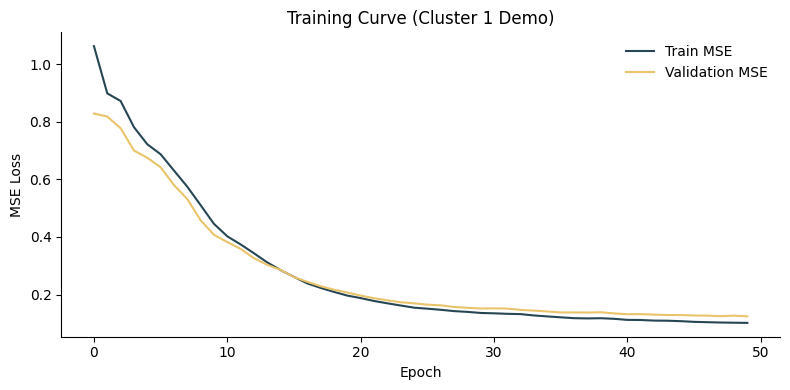

In [76]:
# Optimal config for demonstration on cluster 1
demo_cfg = {
    "val_split": 0.2,
    "seed": 42,
    "batch_size": 512,
    "hidden_dim": 512,
    "latent": 8,
    "num_layers": 4,
    "lr": 0.0003663209242790148,
    "weight_decay": 1e-05,
    "epochs": 50
}

X_cluster_1 = X_base_scaled[cluster_labels == 1]
demo_model, train_losses, val_losses = train_on_cluster(X_cluster_1, in_dim=X_cluster_1.shape[1], cfg=demo_cfg, cid=1)

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train MSE', color='#264653')
plt.plot(val_losses, label='Validation MSE', color='#e9c46a')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Curve (Cluster 1 Demo)')
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## 6. Threshold Tuning and Evaluation
### 6.1 Loading Pretrained Models
We load AutoEncoders that were trained with optimized hyperparameters for each cluster.

As mentioned earlier, these models were trained on DTU's HPC cluster using wandb sweeps to find the best hyperparameters. The final models were saved and are now loaded for evaluation.

In [77]:
import requests

def download_models():
    base_url = "https://raw.githubusercontent.com/sunnakaradottir/data_science/main/models"

    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)

    K = 4
    for cluster_id in range(K):
        os.makedirs(f"models/ae_cluster_{cluster_id}", exist_ok=True)
        config_url = f"{base_url}/ae_cluster_{cluster_id}/ae_cluster_{cluster_id}_config.txt"
        pt_url     = f"{base_url}/ae_cluster_{cluster_id}/ae_cluster_{cluster_id}.pt"
        config_path = f"models/ae_cluster_{cluster_id}/ae_cluster_{cluster_id}_config.txt"
        pt_path     = f"models/ae_cluster_{cluster_id}/ae_cluster_{cluster_id}.pt"
        # Download config
        r = requests.get(config_url)
        with open(config_path, 'wb') as f:
            f.write(r.content)
        print(f"Downloaded {config_path}")
        # Download model weights
        r = requests.get(pt_url)
        with open(pt_path, 'wb') as f:
            f.write(r.content)
        print(f"Downloaded {pt_path}")

def load_pretrained_model(cluster_id, models_dir='models'):
    base_path = f'{models_dir}/ae_cluster_{cluster_id}'
    config = parse_model_config(f'{base_path}/ae_cluster_{cluster_id}_config.txt')

    model = AutoEncoder(
        in_dim=30,
        hidden_units=config['hidden_dim'],
        latent_features=config['latent'],
        num_layers=config['num_layers']
    )
    model.load_state_dict(torch.load(f'{base_path}/ae_cluster_{cluster_id}.pt', map_location='cpu'))
    model.eval()
    print(f"Loaded model for cluster {cluster_id}")
    return model

download_models()
models = {i: load_pretrained_model(i) for i in range(K)}

Downloaded models/ae_cluster_0/ae_cluster_0_config.txt
Downloaded models/ae_cluster_0/ae_cluster_0.pt
Downloaded models/ae_cluster_1/ae_cluster_1_config.txt
Downloaded models/ae_cluster_1/ae_cluster_1.pt
Downloaded models/ae_cluster_2/ae_cluster_2_config.txt
Downloaded models/ae_cluster_2/ae_cluster_2.pt
Downloaded models/ae_cluster_3/ae_cluster_3_config.txt
Downloaded models/ae_cluster_3/ae_cluster_3.pt
Loaded model for cluster 0
Loaded model for cluster 1
Loaded model for cluster 2
Loaded model for cluster 3


### 6.2 Threshold Tuning
To avoid data leakage, we split the tune data into two parts:
- **Tune set (50%)**: Used to find optimal thresholds
- **Test set (50%)**: Used for final evaluation

For each cluster, we find the threshold that maximizes F1 score on the tune set since F1 balances precision and recall.

In [78]:
def compute_reconstruction_errors(model, X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        reconstructed = model(X_tensor)['x_hat']
        errors = F.mse_loss(reconstructed, X_tensor, reduction='none').mean(dim=1)
    return errors.cpu().numpy()

def find_optimal_threshold(errors, y_true, n_thresholds=200):
    thresholds = np.linspace(errors.min(), errors.max(), n_thresholds)
    best_f1, best_threshold = 0, 0
    all_results = []

    for threshold in thresholds:
        preds = (errors > threshold).astype(int)
        tp = ((preds == 1) & (y_true == 1)).sum()
        fp = ((preds == 1) & (y_true == 0)).sum()
        fn = ((preds == 0) & (y_true == 1)).sum()

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        all_results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold

    return best_threshold, best_f1, pd.DataFrame(all_results)

# Prepare tune data
X_tune_all = tune_df.drop(columns=['Class']).values
y_tune_all = tune_df['Class'].values
X_tune_scaled = scaler.transform(X_tune_all)

# Split into tune/test
X_tune, X_test, y_tune, y_test = train_test_split(
    X_tune_scaled, y_tune_all, test_size=0.5, random_state=42, stratify=y_tune_all
)

tune_clusters = kmeans.predict(X_tune)
test_clusters = kmeans.predict(X_test)

# Compute errors and find thresholds for each cluster
cluster_data_tune = {}
optimal_thresholds = []
threshold_results = {}

for cid in range(K):
    mask = tune_clusters == cid
    X_cluster = X_tune[mask]
    y_cluster = y_tune[mask]

    errors = compute_reconstruction_errors(models[cid], X_cluster)
    cluster_data_tune[cid] = {'errors': errors, 'labels': y_cluster}

    thresh, f1, results_df = find_optimal_threshold(errors, y_cluster)
    optimal_thresholds.append(thresh)
    threshold_results[cid] = results_df

    print(f"Cluster {cid}: threshold = {thresh:.4f}, F1 = {f1:.4f}")

Cluster 0: threshold = 0.3039, F1 = 0.8539
Cluster 1: threshold = 0.9604, F1 = 0.9231
Cluster 2: threshold = 3.9564, F1 = 0.8795
Cluster 3: threshold = 1.2800, F1 = 0.9247


/Users/arnormoncada/miniconda3/envs/mnist/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 6.3 Threshold vs Performance (ekki nauðsynlegt, bara uppá gröfin)
These plots show how precision, recall, and F1 change as we vary the threshold for each cluster.

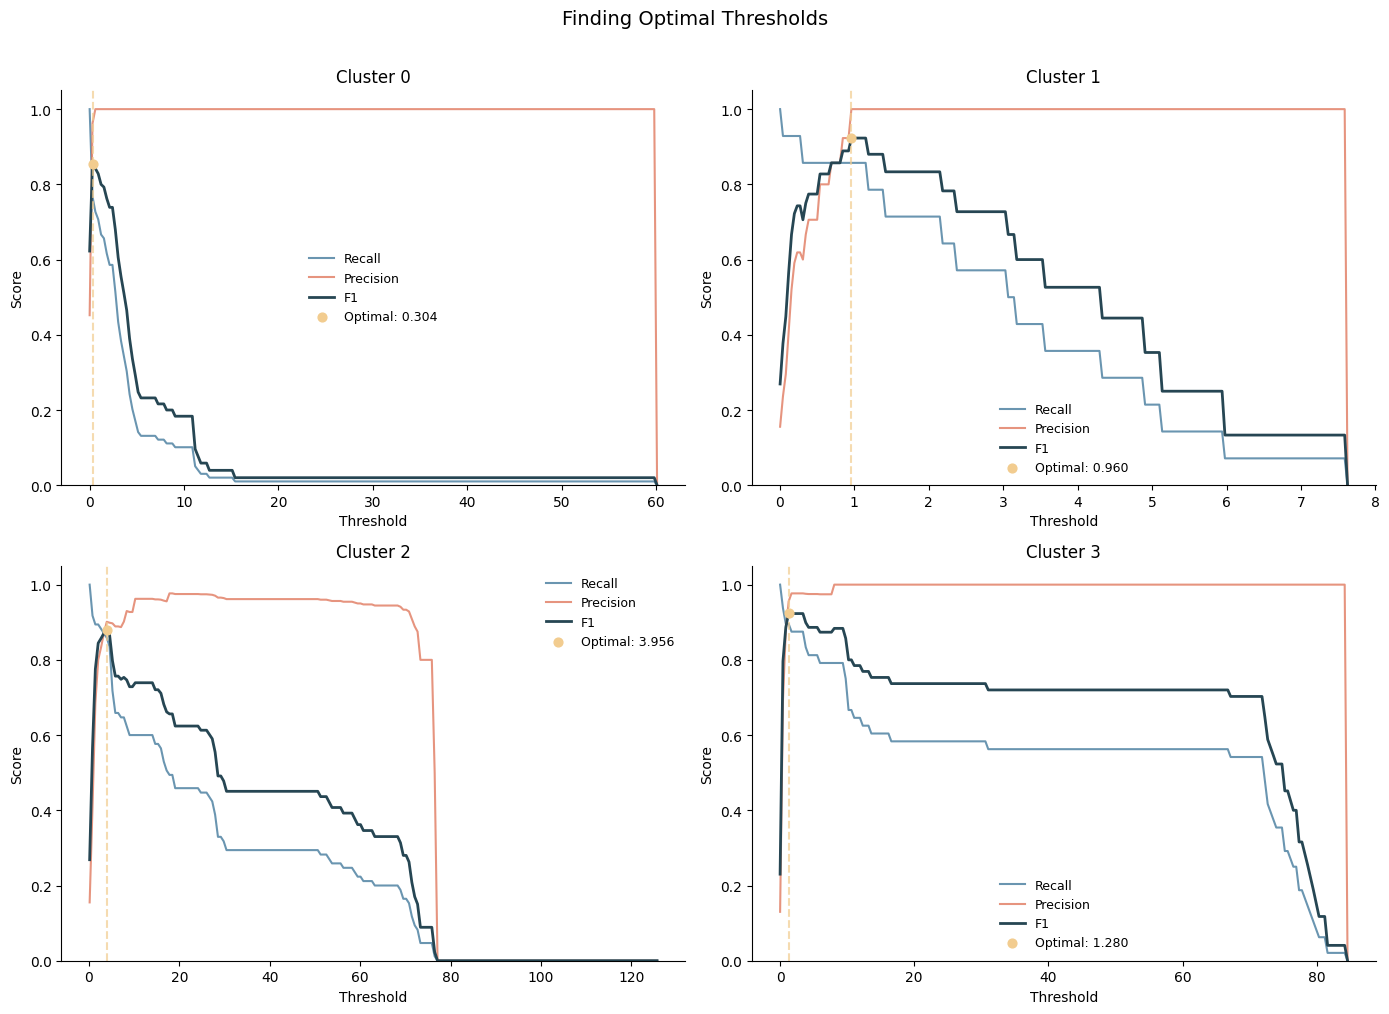

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = {'recall': '#457b9d', 'precision': '#e07a5f', 'f1': '#264653', 'optimal': '#f2cc8f'}

for cid, ax in enumerate(axes.flatten()):
    results_df = threshold_results[cid]

    ax.plot(results_df['threshold'], results_df['recall'], label='Recall', color=colors['recall'], linewidth=1.5, alpha=0.8)
    ax.plot(results_df['threshold'], results_df['precision'], label='Precision', color=colors['precision'], linewidth=1.5, alpha=0.8)
    ax.plot(results_df['threshold'], results_df['f1'], label='F1', color=colors['f1'], linewidth=2)

    best_thresh = optimal_thresholds[cid]
    best_f1 = results_df.loc[results_df['f1'].idxmax(), 'f1']
    ax.axvline(best_thresh, color=colors['optimal'], linestyle='--', linewidth=1.5, alpha=0.7)
    ax.scatter([best_thresh], [best_f1], color=colors['optimal'], s=40, zorder=5, label=f'Optimal: {best_thresh:.3f}')

    ax.set_title(f'Cluster {cid}', fontsize=12)
    ax.set_xlabel('Threshold', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1.05])
    ax.legend(loc='best', frameon=False, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Finding Optimal Thresholds', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 6.4 Final Evaluation
We apply the tuned thresholds to the untouched test set.

In [80]:
cluster_data_test = {}
y_pred_test = np.zeros_like(y_test)

for cid in range(K):
    mask = test_clusters == cid
    X_cluster = X_test[mask]
    y_cluster = y_test[mask]

    errors = compute_reconstruction_errors(models[cid], X_cluster)
    cluster_data_test[cid] = {'errors': errors, 'labels': y_cluster, 'mask': mask}

    preds = (errors > optimal_thresholds[cid]).astype(int)
    y_pred_test[mask] = preds

    f1 = f1_score(y_cluster, preds, zero_division=0)
    print(f"Cluster {cid}: F1 = {f1:.4f}")

# Overall metrics
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f"\nOverall Test Set Results:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1 Score:  {f1:.4f}")

Cluster 0: F1 = 0.8333
Cluster 1: F1 = 0.8800
Cluster 2: F1 = 0.8734
Cluster 3: F1 = 0.8831

Overall Test Set Results:
  Accuracy:  0.9455
  Precision: 0.8874
  Recall:    0.8333
  F1 Score:  0.8595


### 6.5 Confusion Matrix (ekki nauðsynlegt heldur en kannski fyrir reportið?)

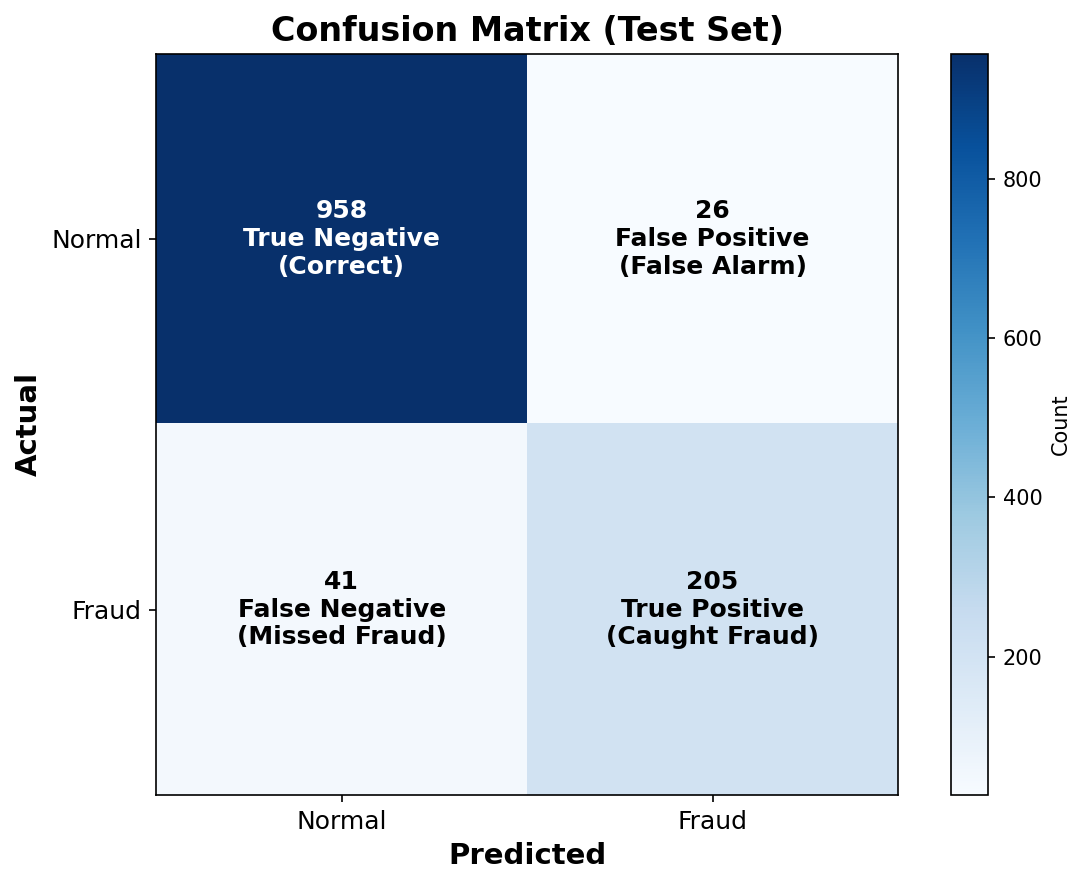

In [81]:
cm = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
im = ax.imshow(cm, cmap='Blues')

labels = [['True Negative\n(Correct)', 'False Positive\n(False Alarm)'],
        ['False Negative\n(Missed Fraud)', 'True Positive\n(Caught Fraud)']]

for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        ax.text(j, i, f'{cm[i, j]}\n{labels[i][j]}', ha='center', va='center', fontsize=12, color=color, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_yticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_xlabel('Predicted', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')

plt.colorbar(im, ax=ax, label='Count')
plt.tight_layout()
plt.show()

# References
[1] DeepLearning, "Unsupervised Learning — Autoencoder," 02456 Deep Learning with PyTorch (DTU). GitHub notebook. Available: https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/7_Unsupervised/7.1-autoencoder.ipynb. Accessed: Nov. 23, 2025.